# COVID-19 USA

## Objetivos deste notebook

Adaptar o [notebook](https://raw.githubusercontent.com/jgrocha/covid-pt/master/Casos%20de%20estudo/COVID-19_USA_statistics/COVID-19_USA_statistics.ipynb) criado por Tiago Pinheiro - A82491 de forma a utilizar dados mais atualizados.

In [1]:
import sys
import os
from osgeo import ogr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qgis.core import *
from qgis.PyQt.QtGui import *
from qgis.PyQt.QtCore import *
from IPython.display import Image

Start Qgis with GUI and start a project

In [2]:
qgis_path = r"C:\OSGeo4W64\apps\qgis"
QgsApplication.setPrefixPath(qgis_path, True)
qgs = QgsApplication([], True)
qgs.initQgis()
sys.path.append(r"C:\OSGeo4W64\apps\qgis\python\plugins")
project = QgsProject.instance()
print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		C:/OSGEO4~1/apps/qgis
Prefix:		C:/OSGEO4~1/apps/qgis
Plugin Path:		C:/OSGEO4~1/apps/qgis/plugins
Package Data Path:	C:/OSGEO4~1/apps/qgis/.
Active Theme Name:	
Active Theme Path:	C:/OSGEO4~1/apps/qgis/./resources/themes\\icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	C:\OSGeo4W64\apps\qgis/./svg/
		C:/OSGEO4~1/apps/qgis/./svg/
		C:/Users/Marcelo/AppData/Roaming/python3\profiles\default/svg/
User DB Path:	C:/OSGEO4~1/apps/qgis/./resources/qgis.db
Auth DB Path:	C:/Users/Marcelo/AppData/Roaming/python3\profiles\default/qgis-auth.db



Download Map

In [3]:
import urllib.request
url = 'https://data.biogeo.ucdavis.edu/data/diva/adm/AUT_adm.zip'
filename = 'AUT_adm.zip'
urllib.request.urlretrieve(url, filename)

('AUT_adm.zip', <http.client.HTTPMessage at 0x201afb81048>)

Unzip Map

In [4]:
import zipfile
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

Load map layer

In [5]:
path = "AUT_adm1.shp"
map_layer = QgsVectorLayer(path, 'PORTUGAL map', 'ogr')

if not map_layer.isValid():
    print("Failed to load the layer!")
else:
    project.addMapLayer(map_layer)
    print("Sucess")

Sucess


Download csv file

In [6]:
import urllib.request
url = 'https://raw.githubusercontent.com/covid19-eu-zh/covid19-eu-data/master/dataset/covid-19-at.csv'
filename = 'covid-19-at.csv'
urllib.request.urlretrieve(url, filename)

('covid-19-at.csv', <http.client.HTTPMessage at 0x201afb9c0b8>)

In [7]:
import csv

with open('covid-19-at.csv', 'r') as i, open('covid-19-austria.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
    for row in r:
        if row[8] == "2020-05-09T15:00:00": 
            writer.writerow(row)
            print(row)

['AT', 'Burgenland', '331', '279', '11', '8255', '6', '0', '2020-05-09T15:00:00']
['AT', 'KÃ¤rnten', '411', '387', '13', '12208', '3', '2', '2020-05-09T15:00:00']
['AT', 'Vorarlberg', '876', '838', '19', '15160', '2', '1', '2020-05-09T15:00:00']
['AT', 'Salzburg', '1212', '1155', '36', '26560', '25', '3', '2020-05-09T15:00:00']
['AT', 'Steiermark', '1796', '1395', '135', '35200', '32', '6', '2020-05-09T15:00:00']
['AT', 'OberÃ¶sterreich', '2267', '2160', '58', '46097', '20', '5', '2020-05-09T15:00:00']
['AT', 'Wien', '2661', '1999', '141', '70226', '110', '19', '2020-05-09T15:00:00']
['AT', 'NiederÃ¶sterreich', '2684', '2405', '95', '39532', '72', '25', '2020-05-09T15:00:00']
['AT', 'Tirol', '3518', '3310', '107', '58452', '39', '18', '2020-05-09T15:00:00']
['AT', '', '15756', '13928', '615', '311690', '309', '79', '2020-05-09T15:00:00']


Load csv file

In [8]:
csv_path = "file:covid-19-austria.csv?delimiter=(',')"
csv_layer = QgsVectorLayer(csv_path, 'Data', 'delimitedtext')

if not csv_layer.isValid():
    print('Layer failed to load!')
else:
    project.addMapLayer(csv_layer)
    print("Sucess")

Sucess


Join layer

In [9]:
joinName = 'name'
targetName = 'NAME_1'

joinObject = QgsVectorLayerJoinInfo()
joinObject.setJoinFieldName(joinName)
joinObject.setTargetFieldName(targetName)
joinObject.setJoinLayerId(csv_layer.id())
joinObject.setUsingMemoryCache(True)
joinObject.setJoinLayer(csv_layer)
flag = map_layer.addJoin(joinObject)

## Gráfico do número de mortes, casos confirmados e casos recuperados

In [10]:
dict = []

for feature in map_layer.getFeatures():
    if feature['NAME_1']:
        state = feature['NAME_1']
        if feature['Data_deaths']:
            death = feature['Data_deaths']
        else:
            death = 0
        if feature['Data_cases']:
            confirmed = feature['Data_cases']
        else:
            confirmed = 0
        if feature['Data_recovered']:
            recovered = feature['Data_recovered']
        else:
            recovered = 0
        if feature['Data_tests']:
            tests = feature['Data_tests']
        else:
            tests = 0
        if feature['Data_hospitalized']:
            hospitalized = feature['Data_hospitalized']
        else:
            hospitalized = 0
        if feature['Data_intensive_care']:
            intensive_care = feature['Data_intensive_care']
        else:
            intensive_care = 0
        
    e = {'Name': state, 'Confirmed': confirmed, 'Death': death, 'Recovered': recovered, 'Tests': tests, 'Hospitalized': hospitalized, 'Intensive care': intensive_care }
    dict.append(e)

In [11]:
size = len(dict)-5

c = sorted(dict, key = lambda i: i['Confirmed'],reverse=True)
d = sorted(dict, key = lambda i: i['Death'],reverse=True)
r = sorted(dict, key = lambda i: i['Recovered'],reverse=True)
t = sorted(dict, key = lambda i: i['Tests'],reverse=True)
h = sorted(dict, key = lambda i: i['Hospitalized'],reverse=True)
i = sorted(dict, key = lambda i: i['Intensive Care'],reverse=True)

top5confirmed = c[0:5]
top5death = d[0:5]
top5recovered = r[0:5]
top5tests = t[0:5]
top5hospitalized = h[0:5]
top5intensive_care = i[0:5]

bottom5confirmed = c[size:]
bottom5death = d[size:]
bottom5recovered = r[size:]
bottom5tests = r[size:]
bottom5hospitalized = h[size:]
bottom5intensive_care = i[size:]

### Top 5 Casos Confirmados

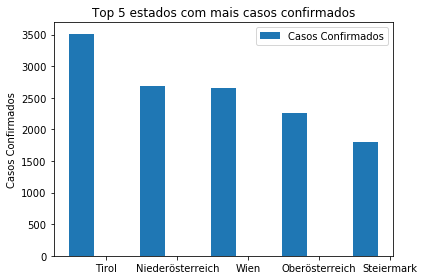

In [12]:
delta1 = [top5confirmed[0]['Confirmed'],top5confirmed[1]['Confirmed'],top5confirmed[2]['Confirmed'],top5confirmed[3]['Confirmed'],top5confirmed[4]['Confirmed']]
states = [top5confirmed[0]['Name'],top5confirmed[1]['Name'],top5confirmed[2]['Name'],top5confirmed[3]['Name'],top5confirmed[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Casos Confirmados')

plt.ylabel('Casos Confirmados')
plt.title('Top 5 estados com mais casos confirmados')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Bottom 5 Casos Confirmados

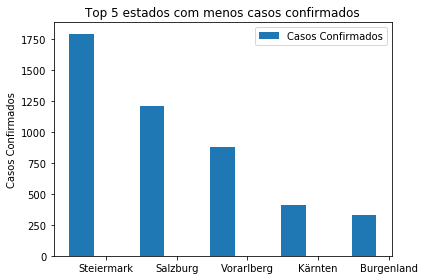

In [13]:
delta1 = [bottom5confirmed[0]['Confirmed'],bottom5confirmed[1]['Confirmed'],bottom5confirmed[2]['Confirmed'],bottom5confirmed[3]['Confirmed'],bottom5confirmed[4]['Confirmed']]
states = [bottom5confirmed[0]['Name'],bottom5confirmed[1]['Name'],bottom5confirmed[2]['Name'],bottom5confirmed[3]['Name'],bottom5confirmed[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Casos Confirmados')

plt.ylabel('Casos Confirmados')
plt.title('Top 5 estados com menos casos confirmados')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Top 5 Mortes

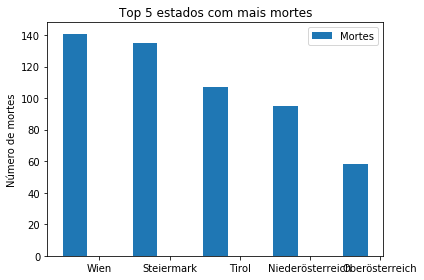

In [14]:
delta1 = [top5death[0]['Death'],top5death[1]['Death'],top5death[2]['Death'],top5death[3]['Death'],top5death[4]['Death']]
states = [top5death[0]['Name'],top5death[1]['Name'],top5death[2]['Name'],top5death[3]['Name'],top5death[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Mortes')

plt.ylabel('Número de mortes')
plt.title('Top 5 estados com mais mortes')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Bottom 5 Mortes

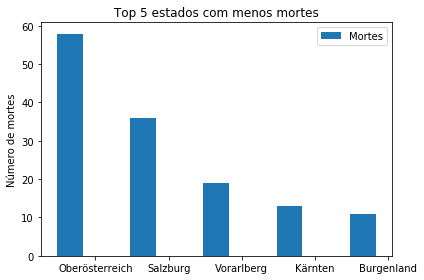

In [15]:
delta1 = [bottom5death[0]['Death'],bottom5death[1]['Death'],bottom5death[2]['Death'],bottom5death[3]['Death'],bottom5death[4]['Death']]
states = [bottom5death[0]['Name'],bottom5death[1]['Name'],bottom5death[2]['Name'],bottom5death[3]['Name'],bottom5death[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Mortes')

plt.ylabel('Número de mortes')
plt.title('Top 5 estados com menos mortes')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Top 5 Casos Recuperados

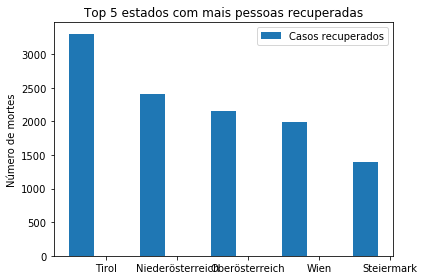

In [16]:
delta1 = [top5recovered[0]['Recovered'],top5recovered[1]['Recovered'],top5recovered[2]['Recovered'],top5recovered[3]['Recovered'],top5recovered[4]['Recovered']]
states = [top5recovered[0]['Name'],top5recovered[1]['Name'],top5recovered[2]['Name'],top5recovered[3]['Name'],top5recovered[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Casos recuperados')

plt.ylabel('Número de mortes')
plt.title('Top 5 estados com mais pessoas recuperadas')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

# Testes

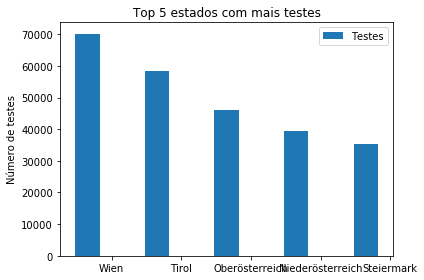

In [21]:
delta1 = [t[0]['Tests'],t[1]['Tests'],t[2]['Tests'],t[3]['Tests'],t[4]['Tests']]
states = [t[0]['Name'],t[1]['Name'],t[2]['Name'],t[3]['Name'],t[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Testes')

plt.ylabel('Número de testes')
plt.title('Top 5 estados com mais testes')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

## Taxa de Mortalidade

Criar uma nova camada para imprimir a taxa de mortalidade

In [18]:
death_layer = map_layer.clone()
death_layer.setName("Death rate")

Eliminar o Alaska, o Hawaii, a Commonwealth of the Northern Mariana Islands, Guam e American Samoa.

In [19]:
delete = []

for feature in death_layer.getFeatures():
    if feature['NAME']=="Alaska" or feature['NAME']=="Hawaii" or feature['NAME']=="Commonwealth of the Northern Mariana Islands" or feature['NAME']=="Guam" or feature['NAME']=="American Samoa": 
        delete.append(feature.id())

res = death_layer.dataProvider().deleteFeatures(delete)

KeyError: 'NAME'

Criar os limites e a graduação das cores

In [ ]:
from qgis.PyQt import QtGui

myOpacity = 1

myTargetField = r'if("Data_Mortality_Rate","Data_Mortality_Rate",-1)'
myRangeList = []

myMin = 0
myMax = 1
myLabel = '< 1%'
myColour = QtGui.QColor('#e6e6ff')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 1
myMax = 3
myLabel = '1% - 3%'
myColour = QtGui.QColor('#ff6666')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 3
myMax = 4
myLabel = '3% - 4%'
myColour = QtGui.QColor('#ff3333')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)


myMin = 4
myMax = 5
myLabel = '4% - 5%'
myColour = QtGui.QColor('#ff0000')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 5
myMax = 6
myLabel = '5% - 6%'
myColour = QtGui.QColor('#cc0000')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 6
myMax = 8
myLabel = '6% - 8%'
myColour = QtGui.QColor('#990000')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 8
myMax = 10
myLabel = '8% - 10%'
myColour = QtGui.QColor('#660000')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 10
myMax = 100
myLabel = '> 14%'
myColour = QtGui.QColor('#000000')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = -1
myMax = -1
myLabel = 'Sem Dados'
myColour = QtGui.QColor('#333333')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)
myRenderer = QgsGraduatedSymbolRenderer('', myRangeList)
myClassificationMethod = QgsApplication.classificationMethodRegistry().method("EqualInterval")
myRenderer.setClassificationMethod(myClassificationMethod)
myRenderer.setClassAttribute(myTargetField)

death_layer.setRenderer(myRenderer)

Layout e Imprimir a imagem

In [ ]:
xt = death_layer.extent()
width  = 1024
height = int(width*xt.height()/xt.width())

manager = project.layoutManager()
layout = QgsPrintLayout(project)
layout.initializeDefaults()
manager.addLayout(layout)

pc = layout.pageCollection()
pc.page(0).attemptResize(QgsLayoutSize(width,height,QgsUnitTypes.LayoutMillimeters))

map = QgsLayoutItemMap(layout)
map.setRect(1,1,1,1)
map.setLayers([death_layer])

options = QgsMapSettings()
options.setLayers([death_layer])
options.setOutputSize(QSize(width, height))
options.setExtent(xt)
map.setExtent(xt)
map.setBackgroundColor(QColor(255, 255, 255))

layout.addLayoutItem(map)

map.attemptMove(QgsLayoutPoint(0,0,QgsUnitTypes.LayoutMillimeters))
map.attemptResize(QgsLayoutSize(width,height,QgsUnitTypes.LayoutMillimeters))

legend = QgsLayoutItemLegend(layout)
legend.setTitle("Legenda:")
layerTree = QgsLayerTree()
layerTree.addLayer(death_layer)
legend.model().setRootGroup(layerTree)

legend.setRect(1,1,1,1)
legend.setScale(3)
legend.setReferencePoint(6)
legend.attemptMove(QgsLayoutPoint(0,320,QgsUnitTypes.LayoutMillimeters))
legend.setLinkedMap(map)
layout.addLayoutItem(legend)
legend.setLegendFilterByMapEnabled(True)
legend.refresh()

exporter = QgsLayoutExporter(layout)
image = exporter.renderPageToImage(0)

imgbuf= QBuffer()
imgbuf.open(QIODevice.ReadWrite)
image.save(imgbuf,"PNG")
Image(imgbuf.data())